# CENG 3526 NLP MIDTERM

To use this code, upload the appropirate *.zip file to colab.

Example code expects the "30Columnists.zip" file be uploded and ready in the GCE backend. 

To do that, you can also mount your **google drive** and use the datasets from there.

Also you can use the **git repo** to download the zip files: 

https://github.com/dtaner/CENG3526/blob/master/30Columnists.zip

or check out (clone) the repo to use datasets.

```
# Clone the entire repo.
!git clone -l -s https://github.com/dtaner/CENG3526.git cloned-repo
%cd cloned-repo
!ls
```

# 2-AUTHOR DETECTION

**OGUZHAN SAHIN 160709027**

**Bag of words and KNN were implemented for this task. It is obviously seems that KNN is does not make sense for multiple classes. I get pretty low accuracy like 22%. When ML algorithms implemented such as Logistic Regression and Support Vector Machines is seems that accuracy is like 86%.**


In [1]:
import io, os
import re as re
import zipfile as zipfile
import numpy as np
import nltk
import time
def read_file(zipname):   
    data = [] 
    labels=[]
    with zipfile.ZipFile(zipname) as z:
        for zipinfo in z.infolist():
            mytextzip = ''
            if zipinfo.filename.endswith('.txt') and re.search('raw_texts', zipinfo.filename):
                labels.append(int(zipinfo.filename.split("/")[2]))
                with z.open(zipinfo) as f:
                    textfile = io.TextIOWrapper(f, encoding='cp1254', newline='')
                    for line in textfile:
                        if len(line.strip()): mytextzip += ' ' + line.strip()   
                    data.append(mytextzip)
    return data,labels
kose_yazilari,labels= read_file('30Columnists.zip')
labels=np.array(labels).reshape(-1,1)

In [2]:
_STOP_WORDS = frozenset([
'a', 'about', 'above', 'above', 'across', 'after', 'afterwards', 'again', 
'against', 'all', 'almost', 'alone', 'along', 'already', 'also','although',
'always','am','among', 'amongst', 'amoungst', 'amount',  'an', 'and', 'another',
'any','anyhow','anyone','anything','anyway', 'anywhere', 'are', 'around', 'as',
'at', 'back','be','became', 'because','become','becomes', 'becoming', 'been', 
'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 
'between', 'beyond', 'bill', 'both', 'bottom','but', 'by', 'call', 'can', 
'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 
'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 
'either', 'eleven','else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 
'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 
'fifteen', 'fify', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 
'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 'further', 'get',
'give', 'go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her', 'here', 
'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 
'himself', 'his', 'how', 'however', 'hundred', 'ie', 'if', 'in', 'inc', 
'indeed', 'interest', 'into', 'is', 'it', 'its', 'itself', 'keep', 'last', 
'latter', 'latterly', 'least', 'less', 'ltd', 'made', 'many', 'may', 'me', 
'meanwhile', 'might', 'mill', 'mine', 'more', 'moreover', 'most', 'mostly', 
'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'never', 
'nevertheless', 'next', 'nine', 'no', 'nobody', 'none', 'noone', 'nor', 'not', 
'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'once', 'one', 'only',
'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out',
'over', 'own','part', 'per', 'perhaps', 'please', 'put', 'rather', 're', 'same',
'see', 'seem', 'seemed', 'seeming', 'seems', 'serious', 'several', 'she', 
'should', 'show', 'side', 'since', 'sincere', 'six', 'sixty', 'so', 'some', 
'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 
'still', 'such', 'system', 'take', 'ten', 'than', 'that', 'the', 'their', 
'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 
'therefore', 'therein', 'thereupon', 'these', 'they', 'thickv', 'thin', 'third',
'this', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 
'to', 'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 
'un', 'under', 'until', 'up', 'upon', 'us', 'very', 'via', 'was', 'we', 'well', 
'were', 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter',
'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 
'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 
'with', 'within', 'without', 'would', 'yet', 'you', 'your', 'yours', 'yourself',
'yourselves', 'the','.',',','?','!','i','s',':'])

In [3]:
def get_tokenize(text):       
    acronym_each_dot = r"(?:[a-z]\.){2,}"
    acronym_end_dot = r"\b[a-z]{2,3}\."
    suffixes = r"[a-z]{3,}' ?[a-z]{0,3}"
    numbers = r"\d+[.,:\d]+"
    any_word = r"[a-z]+"
    punctuations = r"[a-z]*[.,!?;:]"
    word_regex = "|".join([acronym_each_dot,
                           acronym_end_dot,
                           suffixes,
                           numbers,
                           any_word,
                           punctuations])    
    return re.compile("%s"%word_regex, re.I).findall(text)

In [4]:
def clean_text(corpus):  
    start = time.time()
    cleaned_words = []   
    for text in corpus:
        text = text.lower()
        text = get_tokenize(text)
        text = [y for y in text if not y in _STOP_WORDS]
        stem =nltk.PorterStemmer()
        text = [stem.stem(word)for word in text]
        text =" ".join(text)
        cleaned_words.append(text) 
    finish=time.time()
    print(f"It takes {finish-start} seconds to clean. ")
    return cleaned_words
cleaned_text = clean_text(kose_yazilari)
del(kose_yazilari)

It takes 11.994996309280396 seconds to clean. 


In [5]:
def create_word_freq(corpus,n):
    word_freq = dict()
    for document in corpus:    
        tokens = get_tokenize(document)
        for token in tokens:
            if token in word_freq.keys():
                word_freq[token] +=1        
            else:
                word_freq[token]=1  
    most_freq = sorted(word_freq.items(),key=lambda x:x[1],reverse=True)
    return dict(most_freq[:n])

most_freq =create_word_freq(cleaned_text,1000)

In [6]:
def create_bow(corpus):  
    sentence_vectors = []
    for document in corpus:
        sentence_tokens = get_tokenize(document)
        sent_vec=[]
        for token in most_freq:        
            if token in sentence_tokens:
                sent_vec.append(1)
            else:
                sent_vec.append(0)   
        sentence_vectors.append(sent_vec)
    sentence_vectors = np.asarray(sentence_vectors)
    return sentence_vectors

bow = create_bow(cleaned_text)

In [7]:
def train_test_split(x,y,test_size):
    xy = np.concatenate((x,y),axis=1)
    np.random.shuffle(xy)
    test_size = test_size*x.shape[0]
    
    x = xy[...,:-1]
    y = xy[...,-1]
    
    x_train = x[int(test_size):]
    x_test  = x[:int(test_size)]
    y_train = y[int(test_size):].reshape(-1,1)
    y_test  = y[:int(test_size)].reshape(-1,1)
    
    return x_train,x_test,y_train,y_test

x_train,x_test,y_train,y_test = train_test_split(bow,labels,test_size=0.1)

In [8]:
def euclidean_distance(x1, x2):   
        return np.sqrt(np.sum((x1 - x2)**2))   
def _predict(x_test,k):   
    distances= [euclidean_distance(x_test, x_) for x_ in x_train]
    distances = np.asarray(distances)
    k_indexs = np.argsort(distances)[:k]
    k_neighbours_labels = [y_train[i] for i in k_indexs] 
    counts=dict()
    for i in k_neighbours_labels:
        for j in i:
            if j in counts.keys():
                counts[j]+=1
            else:
                counts[j]=1
    most_freq = sorted(counts.items(),key=lambda x:x[1],reverse=True)
    return most_freq[0][0]

def predict(test,k):   
    predictions=[]
    for i in test:   
        predictions.append(_predict(i,k))       
    return np.array(predictions)

In [9]:
predictions = predict(x_test,5).reshape(-1,1)
accuracy  = np.sum(y_test == predictions)/len(y_test)*100
print(accuracy)

22.666666666666664


In [10]:
score_list = []
for each in range(1,10):        
    prediction =predict(x_test,each).reshape(-1,1)
    accuracy  = np.sum(y_test == prediction)/len(y_test)*100  
    score_list.append(accuracy)


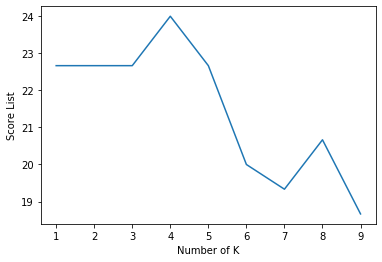

In [11]:
import matplotlib.pyplot as plt
plt.plot([each for each in range(1,10)],score_list)
plt.xlabel("Number of K")
plt.ylabel("Score List")
plt.show()


In [12]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train,y_train)

y_predict_lr=lr.predict(x_test).reshape(-1,1)
accuracy  = np.sum(y_test == y_predict_lr)/len(y_test)*100
print(f"accuracy is :{accuracy} ")

C:\Users\Ogi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy is :88.0 


C:\Users\Ogi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [13]:
from sklearn.svm import SVC

svm = SVC(random_state=42)
svm.fit(x_train,y_train)
y_predict_svm = svm.predict(x_test).reshape(-1,1)
accuracy  = np.sum(y_test == y_predict_svm)/len(y_test)*100
print(f"accuracy is :{accuracy} ")

C:\Users\Ogi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy is :84.66666666666667 


In [14]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(x_train,y_train)


print("Score :",dt.score(x_test,y_test))

Score : 0.36666666666666664


In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=30,random_state=2)

rf.fit(x_train,y_train)

print("Score : ",rf.score(x_test,y_test))

C:\Users\Ogi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Score :  0.6266666666666667
